In [45]:
import plotly.graph_objects as go
import networkx as nx

# reading input log file

test_name = "seq10f9s"

stat_path=f"../example_stat/{test_name}"
image_path=f"{stat_path}/images"

In [46]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk

# Improve Functions
## TODO
- MAYBE: Add adjustment of label to full label, file-task label, and no lables

## DONE
- DONE: Add task start option for graphs
    - Be careful about adding the required files??!!
- DONE: Add task cutoff option for graphs 
- DONE: (Maybe) add time for x-axis
- DONE: store the statistics to edges!!!

In [47]:
STAGE_START = 0
STAGE_END = 10


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


STAGE_END is not in TASK_ORDER_LIST, set to max order: 8
TASK_ORDER_LIST = {'run_idfeature': 0, 'run_tracksingle': 1, 'run_gettracks': 2, 'run_trackstats': 3, 'run_identifymcs': 4, 'run_matchpf': 5, 'run_robustmcs': 6, 'run_mapfeature': 7, 'run_speed': 8}


['run_idfeature',
 'run_tracksingle',
 'run_gettracks',
 'run_trackstats',
 'run_identifymcs',
 'run_matchpf',
 'run_robustmcs',
 'run_mapfeature',
 'run_speed']

In [48]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(vfd_files)

vfd_dict = sload.load_stat_yaml(vfd_files)
# print(vfd_dict)

print("loading yaml done")

['../example_stat/seq10f9s/222745-vfd_data_stat.yaml']
loading ../example_stat/seq10f9s/222745-vfd_data_stat.yaml


loading yaml done


In [62]:
# Show VFD Tracker overhead
sp.show_all_overhead("VFD", vfd_dict)

loading ../example_stat/seq10f9s/222745-vfd_data_stat.yaml


KeyboardInterrupt: 

In [49]:
G_VFD = nx.DiGraph()
G_VFD = vfd2g.add_task_file_nodes(G_VFD, vfd_dict, TASK_LISTS)

stat_file: ../example_stat/seq10f9s/222745-vfd_data_stat.yaml
Unknown access_type: not_accessed
Unknown access_type: not_accessed
Unknown access_type: not_accessed
Unknown access_type: not_accessed
Unknown access_type: not_accessed


In [50]:
task_file_map = sload.load_task_file_map(stat_path, test_name, TASK_LISTS)

for task, stat in task_file_map.items():
    print(f"{task} : {stat}")

task_file_map = {'run_idfeature-222745': {'input': ['/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_02:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_03:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_04:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_05:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfradar3d_wrf/wrfout_rainrate_tb_zh_mh_2015-05-06_06:00:00.nc', '/home/mtang11/experiments/flextrkr_runs/input_data/run_mcs_tbpfra

In [51]:
G_VFD = vfd2g.set_task_position(G_VFD, task_file_map)

task_name: run_idfeature-222745, task_order: 0
node run_idfeature-222745 : {'pos': (0, 0), 'rpos': 0, 'order': 2, 'type': 'task'}, pos: (0, 0)
node : run_idfeature-222745, pos: (0, 0)
task_name: run_tracksingle-222745, task_order: 1
node run_tracksingle-222745 : {'pos': (0, 0), 'rpos': 0, 'order': 21, 'type': 'task'}, pos: (0, 0)
node : run_tracksingle-222745, pos: (2, 0)
task_name: run_gettracks-222745, task_order: 2
node run_gettracks-222745 : {'pos': (0, 0), 'rpos': 0, 'order': 66, 'type': 'task'}, pos: (0, 0)
node : run_gettracks-222745, pos: (4, 0)
task_name: run_trackstats-222745, task_order: 3
node run_trackstats-222745 : {'pos': (0, 0), 'rpos': 0, 'order': 95, 'type': 'task'}, pos: (0, 0)
node : run_trackstats-222745, pos: (6, 0)
task_name: run_identifymcs-222745, task_order: 4
node run_identifymcs-222745 : {'pos': (0, 0), 'rpos': 0, 'order': 109, 'type': 'task'}, pos: (0, 0)
node : run_identifymcs-222745, pos: (8, 0)
task_name: run_matchpf-222745, task_order: 5
node run_matchp

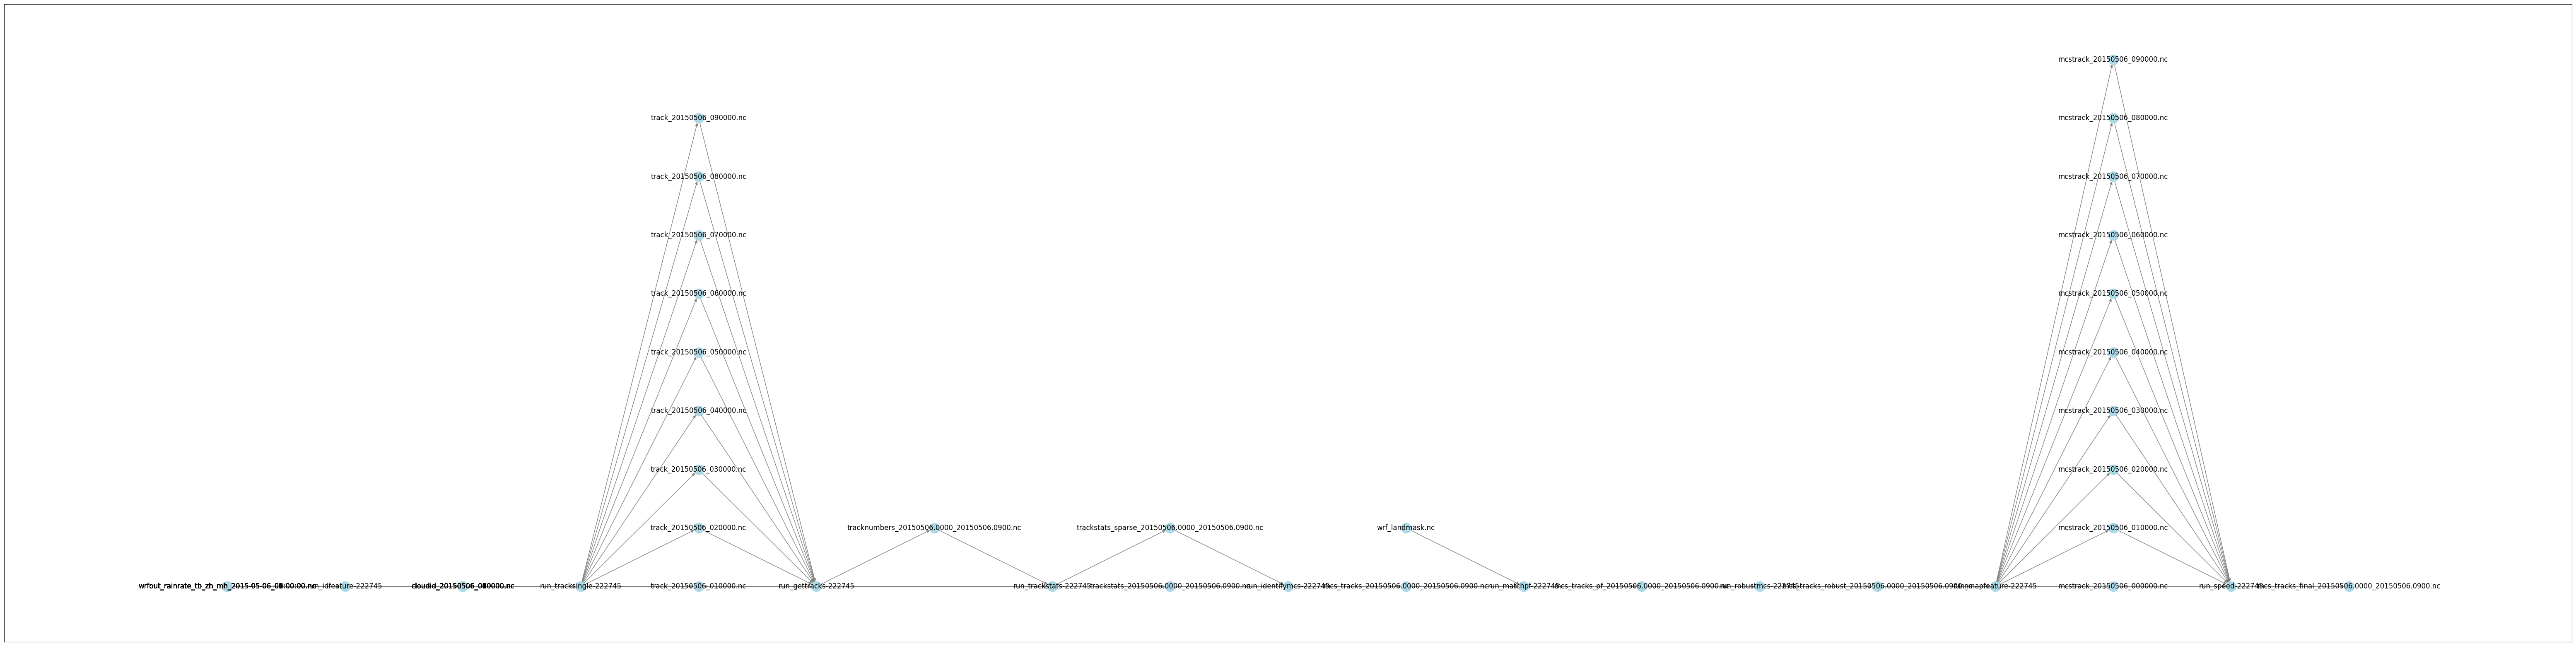

In [52]:
# sp.display_all_nodes_attr(G_VFD)
G_VFD = vfd2g.set_file_position(G_VFD, task_file_map)
# sp.display_all_nodes_attr(G_VFD)

sp.draw_graph(G_VFD, test_name, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [53]:
vfd2g.prepare_sankey_stat(G_VFD)

In [54]:
vfd2sk.time_to_file_x_pos(G_VFD)

All tasks:  ['run_idfeature-222745', 'run_tracksingle-222745', 'run_gettracks-222745', 'run_trackstats-222745', 'run_identifymcs-222745', 'run_matchpf-222745', 'run_robustmcs-222745', 'run_mapfeature-222745', 'run_speed-222745']
wrfout_rainrate_tb_zh_mh_2015-05-06_00:00:00.nc New pos:  (-1.0, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_01:00:00.nc New pos:  (-0.9444444444444444, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_02:00:00.nc New pos:  (-0.8888888888888888, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_03:00:00.nc New pos:  (-0.8333333333333334, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_04:00:00.nc New pos:  (-0.7777777777777778, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_05:00:00.nc New pos:  (-0.7222222222222222, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_06:00:00.nc New pos:  (-0.6666666666666667, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_07:00:00.nc New pos:  (-0.6111111111111112, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_08:00:00.nc New pos:  (-0.5555555555555556, 0)
wrfout_rainrate_tb_zh_mh_2015-05-06_09:

In [61]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

fig.update_layout(
    autosize=False,
    width=4200,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=100,
        pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 4.01 KB/s ~ 14.27 MB/s


Sankey saved to ../example_stat/seq10f9s/vfd-9s-seq10f9s-sankey-labeled-s4.html


In [56]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 123
Total I/O size: 540.32 MB
Total I/O count: 104177
Total bandwidth: 330.47 MB/s
Average I/O size: 5.19 KB
Medium I/O size: 2.28 MB
Inital input size: 163.45 MB



loading ../example_stat/seq10f9s/222745-vfd_data_stat.yaml


Total overhead: 39088.0 ms
Total POSIX IO time: 109506.0 ms


In [58]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
